In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import csv
import json
from scipy.stats import linregress
from config import api_key

In [279]:
mlb_kaggle_latest = 'Resources/mlb_elo_latest.csv'
mlb_kaggle = 'Resources/mlb_elo.csv'
city_alt_csv = 'output_data/city_altitude.csv'
team_name_csv = 'output_data/team_name.csv'

city_alt_df = pd.read_csv(city_alt_csv)
team_name_df = pd.read_csv(team_name_csv)

complete_ID_df = pd.merge(team_name_df, city_alt_df, how='right', on=['stadium ID', 'stadium ID'])
cleaned_ID_df = complete_ID_df[complete_ID_df['team city'].notna()]
cleaned_ID_df
cleaned_ID_df.to_csv('output_data/complete_team_stadium.csv', index=False)

In [255]:
kag_latest_df = pd.read_csv(mlb_kaggle_latest)
kag_og_df = pd.read_csv(mlb_kaggle)
kag_og_df

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2021-10-03,2021,0,NaN,ATL,NYM,1520.302033,1511.617803,0.546898,0.453102,...,NaN,NaN,NaN,NaN,0.514740,0.485260,NaN,NaN,NaN,NaN
1,2021-10-03,2021,0,NaN,STL,CHC,1519.691110,1525.797177,0.525729,0.474271,...,NaN,NaN,NaN,NaN,0.527320,0.472680,NaN,NaN,NaN,NaN
2,2021-10-03,2021,0,NaN,SEA,ANA,1479.484611,1478.455457,0.535958,0.464042,...,NaN,NaN,NaN,NaN,0.499610,0.500390,NaN,NaN,NaN,NaN
3,2021-10-03,2021,0,NaN,LAD,MIL,1579.554567,1502.598988,0.641331,0.358669,...,NaN,NaN,NaN,NaN,0.646189,0.353811,NaN,NaN,NaN,NaN
4,2021-10-03,2021,0,NaN,KCR,MIN,1473.202406,1498.953739,0.497480,0.502520,...,NaN,NaN,NaN,NaN,0.472238,0.527762,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223383,1871-05-09,1871,0,NaN,TRO,ATL,1450.000000,1451.483000,0.532359,0.467641,...,NaN,NaN,NaN,NaN,0.522460,0.477540,1448.525,1452.958,5.0,9.0
223384,1871-05-08,1871,0,NaN,CHC,CL1,1450.000000,1451.943000,0.531700,0.468300,...,NaN,NaN,NaN,NaN,0.528402,0.471598,1451.256,1450.687,14.0,12.0
223385,1871-05-06,1871,0,NaN,RC1,CL1,1450.000000,1448.754000,0.536268,0.463732,...,NaN,NaN,NaN,NaN,0.532974,0.467026,1446.810,1451.943,4.0,12.0
223386,1871-05-05,1871,0,NaN,WS3,ATL,1450.000000,1450.000000,0.534484,0.465516,...,NaN,NaN,NaN,NaN,0.534484,0.465516,1448.517,1451.483,18.0,20.0


In [74]:
filtered_data = kag_og_df[(kag_og_df['season'] >= 1900) & (kag_og_df['season'] <= 2019)]
filtered_data.tail()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
204083,1900-04-20,1900,0,NaN,PHI,ATL,1538.697,1548.944,0.519782,0.480218,...,NaN,NaN,NaN,NaN,0.519877,0.480123,1539.972,1547.559,5.0,4.0
204084,1900-04-19,1900,0,NaN,STL,PIT,1503.240,1516.607,0.515297,0.484703,...,NaN,NaN,NaN,NaN,0.518995,0.481005,1505.333,1514.684,3.0,0.0
204085,1900-04-19,1900,0,NaN,SFG,LAD,1476.101,1541.571,0.440602,0.559398,...,NaN,NaN,NaN,NaN,0.443621,0.556379,1474.944,1542.788,2.0,3.0
204086,1900-04-19,1900,0,NaN,CIN,CHC,1519.974,1507.474,0.552335,0.447665,...,NaN,NaN,NaN,NaN,0.555300,0.444700,1517.559,1509.748,10.0,13.0
204087,1900-04-19,1900,0,NaN,ATL,PHI,1550.730,1536.910,0.554213,0.445787,...,NaN,NaN,NaN,NaN,0.557996,0.442004,1548.856,1538.675,17.0,19.0


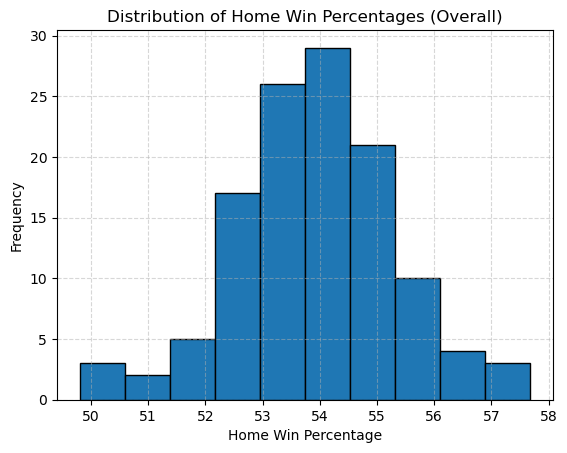

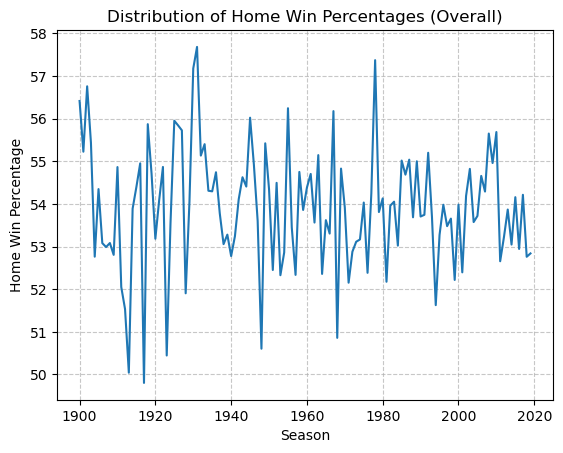

In [317]:
def home_team_advantage(filtered_data, graph_title, fig1, fig2):
    home_clean_df = pd.DataFrame({
        'season': filtered_data['season'],
        'home score': filtered_data['score1'].astype(int),
        'away score': filtered_data['score2'].astype(int)

    })
    home_clean_df['Home Win'] = (
        home_clean_df['home score'] > home_clean_df['away score'] )

    home_win = home_clean_df[home_clean_df['Home Win'] == True]
    away_win = home_clean_df[home_clean_df['Home Win'] == False]

    home_totals = home_win.groupby('season')['Home Win'].count()
    away_totals = away_win.groupby('season')['Home Win'].count()

    totals_df = pd.DataFrame({
        'Home Wins': home_totals,
        'Away Wins': away_totals
    })

    total_matches = totals_df['Home Wins'] + totals_df['Away Wins']
    home_percentage = (totals_df['Home Wins'] / total_matches) * 100
    home_percentage
    plt.hist(home_percentage, edgecolor='black')
    plt.xlabel('Home Win Percentage')
    plt.ylabel('Frequency')  
    plt.title(graph_title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(fig1) 
    plt.show()
    
    plt.plot(home_percentage.index, home_percentage.values, linestyle='-')
    plt.xlabel('Season')
    plt.ylabel('Home Win Percentage')  
    plt.title(graph_title) 
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.savefig(fig2) 
    plt.show()
    return home_percentage

overall_title = 'Distribution of Home Win Percentages (Overall)'
overall_fig1 = 'output_data/overall_fig1.png'
overall_fig2 = 'output_data/overall_fig2.png'

home_percentage_overall = home_team_advantage(filtered_data, overall_title, overall_fig1, overall_fig2)


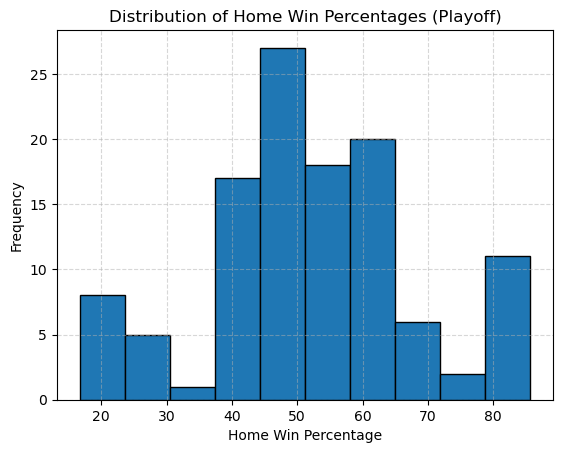

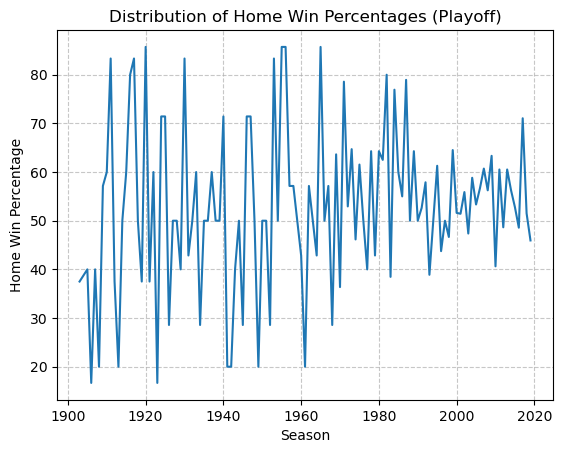

In [319]:
playoff_df = filtered_data[filtered_data['playoff'].notna()]
playoff_title = 'Distribution of Home Win Percentages (Playoff)'
playoff_fig1 = 'output_data/playoff_fig1.png'
playoff_fig2 = 'output_data/playoff_fig2.png'

home_percentage_playoff = home_team_advantage(playoff_df, playoff_title, playoff_fig1, playoff_fig2)

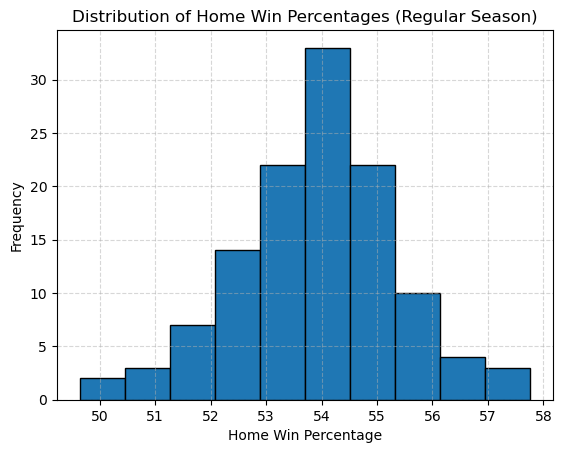

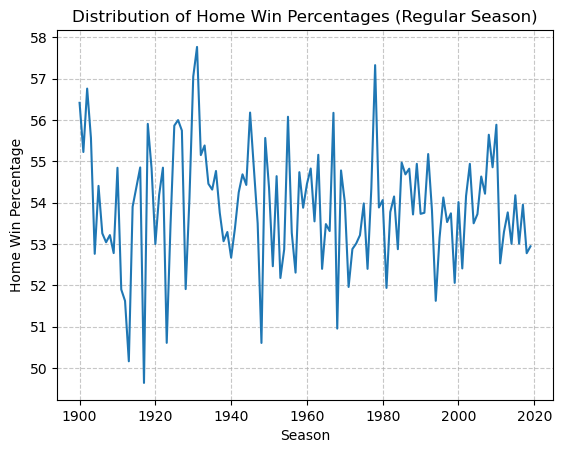

In [320]:
reg_season_df = filtered_data[filtered_data['playoff'].isnull()]
reg_title = 'Distribution of Home Win Percentages (Regular Season)'
reg_fig1 = 'output_data/reg_fig1.png'
reg_fig2 = 'output_data/reg_fig2.png'
home_percentage_season = home_team_advantage(reg_season_df, reg_title, reg_fig1, reg_fig2)

## average elo rating home vs away correlate to win

In [271]:
base_url = 'https://api.sportsdata.io/v3/mlb/scores/json/Stadiums?'
params = {
    'key': api_key
}

response = requests.get(base_url, params=params)
response = response.json()
print(json.dumps(response[0], indent=4, sort_keys=True))

city_altitude = {
    'stadium city':[],
    'altitude': [],
    'stadium ID':[]
}

for i in range(len(response)):
    city = response[i]['City']
    altitude = response[i]['Altitude']
    stadiumID = response[i]['StadiumID']
    
    if (altitude is not None):
        city_altitude['stadium city'].append(city)
        city_altitude['altitude'].append(altitude)
        city_altitude['stadium ID'].append(stadiumID)
print(json.dumps(city_altitude, indent=4))

city_alt_df = pd.DataFrame(city_altitude)
city_alt_df.to_csv('output_data/city_altitude.csv', index=False)

{
    "Active": true,
    "Altitude": 14,
    "Capacity": 40209,
    "CenterField": 396,
    "City": "San Diego",
    "Country": "USA",
    "GeoLat": 32.7073,
    "GeoLong": -117.1566,
    "HomePlateDirection": 180,
    "LeftCenterField": 367,
    "LeftField": 334,
    "MidLeftCenterField": 402,
    "MidLeftField": 351,
    "MidRightCenterField": 403,
    "MidRightField": 351,
    "Name": "PETCO Park",
    "RightCenterField": 378,
    "RightField": 322,
    "StadiumID": 1,
    "State": "CA",
    "Surface": "Grass",
    "Type": "Outdoor"
}
{
    "stadium city": [
        "San Diego",
        "Atlanta",
        "New York",
        "Cleveland",
        "San Francisco",
        "Minneapolis",
        "St. Petersburg",
        "Milwaukee",
        "Arlington",
        "Baltimore",
        "Oakland",
        "Chicago",
        "London",
        "Chicago",
        "Anaheim",
        "Pittsburgh",
        "Los Angeles",
        "Kansas City",
        "New York",
        "St. Louis",
        "T

In [270]:
base_url = 'https://api.sportsdata.io/v3/mlb/scores/json/teams?'
params = {
    'key': api_key
}


response = requests.get(base_url, params=params)
response = response.json()
# print(json.dumps(response, indent=4, sort_keys=True))
city_team = {
    'team city':[],
    'team':[],
    'team key':[],
    'stadium ID':[]
}

for i in range(len(response)):
    city = response[i]['City']
    team = response[i]['Name']
    key = response[i]['Key']
    stadiumID = response[i]['StadiumID']
    
    city_team['team city'].append(city)
    city_team['team'].append(team)
    city_team['team key'].append(key)
    city_team['stadium ID'].append(stadiumID)
    
print(json.dumps(city_team, indent=4))

city_alt_df = pd.DataFrame(city_team)
city_alt_df.to_csv('output_data/team_name.csv', index=False)  

{
    "team city": [
        "Los Angeles",
        "Cincinnati",
        "Toronto",
        "Pittsburgh",
        "Kansas City",
        "Chicago",
        "Cleveland",
        "Tampa Bay",
        "Philadelphia",
        "Seattle",
        "Arizona",
        "San Francisco",
        "Chicago",
        "Detroit",
        "New York",
        "Baltimore",
        "Minnesota",
        "Los Angeles",
        "Miami",
        "Colorado",
        "Oakland",
        "Boston",
        "Atlanta",
        "Texas",
        "New York",
        "Houston",
        "St. Louis",
        "Milwaukee",
        "San Diego",
        "Washington"
    ],
    "team": [
        "Dodgers",
        "Reds",
        "Blue Jays",
        "Pirates",
        "Royals",
        "Cubs",
        "Guardians",
        "Rays",
        "Phillies",
        "Mariners",
        "Diamondbacks",
        "Giants",
        "White Sox",
        "Tigers",
        "Mets",
        "Orioles",
        "Twins",
        "Angels",
        